In [5]:
import numpy as np
import pandas as pd
import string
from tqdm import tqdm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [9]:
text_array = []
stop_words = set(stopwords.words("english"))
with open('filename.txt', 'r') as file:
    text_read = file.read().replace('\n', '')
text_read = text_read.translate(str.maketrans('', '', string.punctuation))
text_read = text_read.replace('”', '').replace('“', '').replace('’', '').lower()
print(text_read)
text_array = nltk.word_tokenize(text_read)
print(text_array)

text = []
for word in text_array:
    if word.casefold() not in stop_words:
        text.append(word)
        


today we will be learning about the fundamentals of data science and statistics data science and statistics are hot and growing fields with alternative names of machine learning artificial intelligence big data etc im really excited to talk to you about data science and statistics because data science and statistics have long been a passions of mine i didnt used to be very good at data science and statistics but after studying data science and statistics for a long time i got better and better at it until i became a data science and statistics expert im really excited to talk to you about data science and statistics thanks for listening to me talk about data science and statistics
['today', 'we', 'will', 'be', 'learning', 'about', 'the', 'fundamentals', 'of', 'data', 'science', 'and', 'statistics', 'data', 'science', 'and', 'statistics', 'are', 'hot', 'and', 'growing', 'fields', 'with', 'alternative', 'names', 'of', 'machine', 'learning', 'artificial', 'intelligence', 'big', 'data', 'e

In [10]:
WINDOW_SIZE = 3
NUM_NEGATIVE_SAMPLES = 3

data = []

#iterate over all words
for idx,center_word in enumerate(text[WINDOW_SIZE-1:-WINDOW_SIZE]):
    print(center_word)
    #iterate over the context words around the center word
    context_words = [context_word for context_word in text[idx:idx+2*WINDOW_SIZE-1] if context_word != center_word]
    for context_word in context_words:
        
        #get words NOT in the current context as negative examples
        data.append([center_word, context_word, 1])
        negative_samples = np.random.choice([w for w in text[WINDOW_SIZE-1:-WINDOW_SIZE] if w != center_word and w not in context_words], NUM_NEGATIVE_SAMPLES)
        
        for negative_samp in negative_samples:
            
            #add a training row
            data.append([center_word, negative_samp, 0])


fundamentals
data
science
statistics
data
science
statistics
hot
growing
fields
alternative
names
machine
learning
artificial
intelligence
big
data
etc
im
really
excited
talk
data
science
statistics
data
science
statistics
long
passions
mine
didnt
used
good
data
science
statistics
studying
data
science
statistics
long
time
got
better
better
became
data
science
statistics
expert
im
really
excited
talk
data
science
statistics
thanks
listening
talk


In [11]:
df = pd.DataFrame(columns=['center_word', 'context_word', 'label'], data=data)
words = np.intersect1d(df.context_word, df.center_word)
df = df[(df.center_word.isin(words)) & (df.context_word.isin(words))].reset_index(drop=True)


In [26]:
df.head()
# df

,center_word,context_word,label
0,fundamentals,used,0
1,fundamentals,excited,0
2,fundamentals,talk,0
3,fundamentals,learning,1
4,fundamentals,excited,0


In [27]:
df

,center_word,context_word,label
0,fundamentals,used,0
1,fundamentals,excited,0
2,fundamentals,talk,0
3,fundamentals,learning,1
4,fundamentals,excited,0
...,...,...,...
978,talk,better,0
979,talk,science,1
980,talk,statistics,0
981,talk,excited,0


In [13]:
def sigmoid(v, scale=1):
    return 1 / (1 + np.exp(-scale*v))

In [14]:
def update_embeddings(df, main_embeddings, context_embeddings, learning_rate, debug=False):
    
    #get differences between main embeddings and corresponding context embeddings
    main_embeddings_center = main_embeddings.loc[df.center_word].values
    context_embeddings_context = context_embeddings.loc[df.context_word].values
    diffs = context_embeddings_context - main_embeddings_center
    
    #get similarities, scores, and errors between main embeddings and corresponding context embeddings
    dot_prods = np.sum(main_embeddings_center * context_embeddings_context, axis=1)
    scores = sigmoid(dot_prods)
    errors = (df.label - scores).values.reshape(-1,1)
    
    #calculate updates
    updates = diffs*errors*learning_rate
    updates_df = pd.DataFrame(data=updates)
    updates_df['center_word'] = df.center_word
    updates_df['context_word'] = df.context_word
    updates_df_center = updates_df.groupby('center_word').sum()
    updates_df_context = updates_df.groupby('context_word').sum()
    
    if debug:
        plot_words(debug)
    
    #apply updates
    main_embeddings += updates_df_center.loc[main_embeddings.index]
    context_embeddings -= updates_df_context.loc[context_embeddings.index]
    
    #normalize embeddings
    main_embeddings = normalize_data(main_embeddings)
    context_embeddings = normalize_data(context_embeddings)
    
    #return the updated embeddings
    return main_embeddings, context_embeddings

In [15]:
def normalize_data(data):
    row_norms = np.sqrt((data.values**2).sum(axis=1)).reshape(-1,1)
    return data.divide(row_norms, axis='index')

In [16]:
def plot_words(debug):
    plt.figure(figsize=(8,4))
    
    plt.subplot(1,2,1)
    lim_main_first = main_embeddings.loc[[debug[0]]]
    lim_main_second = main_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main_first[0], lim_main_first[1], color='r')
    plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_first.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_main_second[0], lim_main_second[1], color='r')
    plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_second.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], main_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    t = np.arange(0, 3.14*2+0.1, 0.1)
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    
    ###################################
    
    plt.subplot(1,2,2)
    lim_main = main_embeddings.loc[[debug[0]]]
    lim_context = context_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main[0], lim_main[1], color='r')
    plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_context[0], lim_context[1], color='b')
    plt.arrow(0,0,float(lim_context[0]), float(lim_context[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_context.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], context_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    
    plt.show()

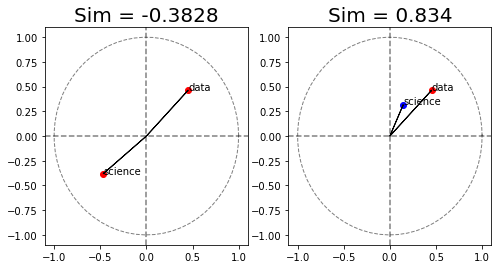

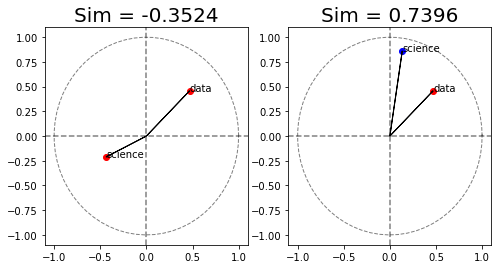

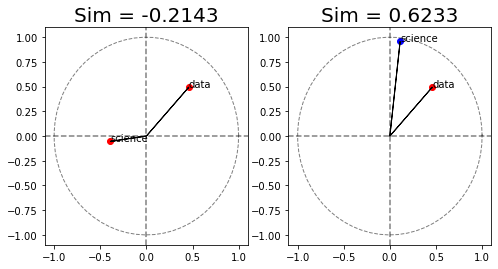

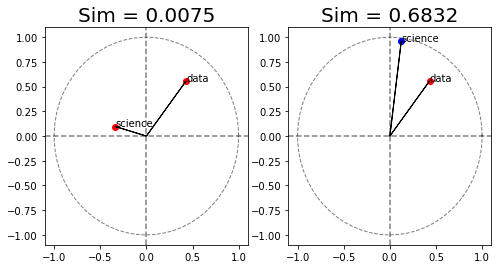

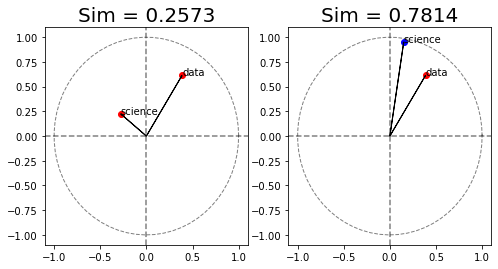

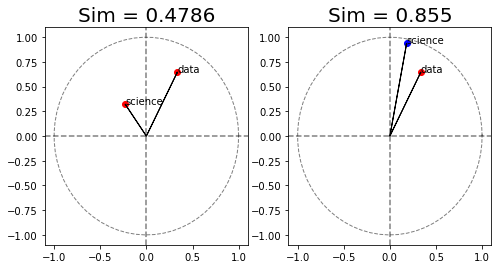

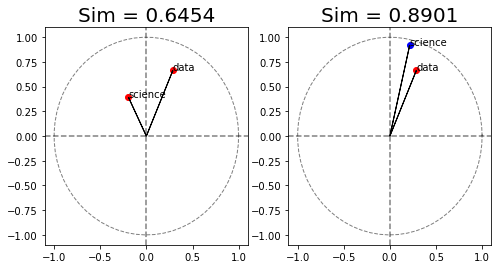

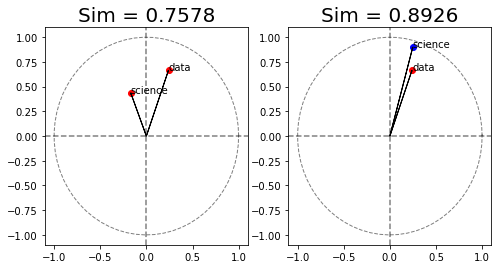

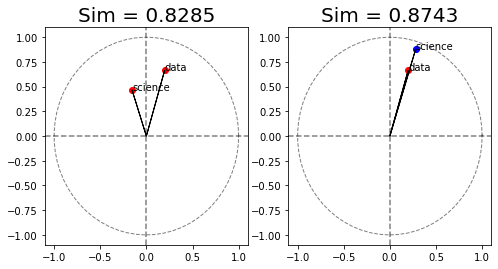

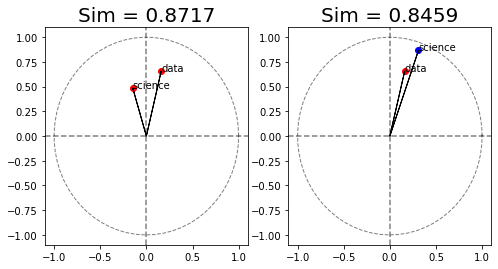

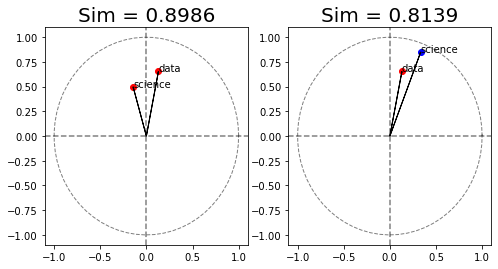

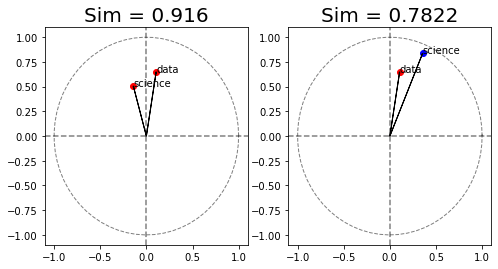

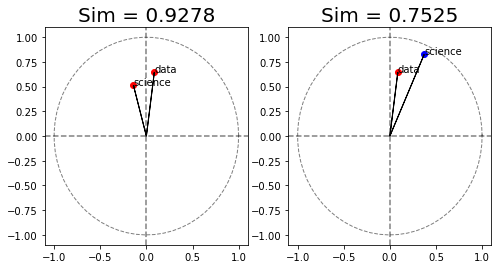

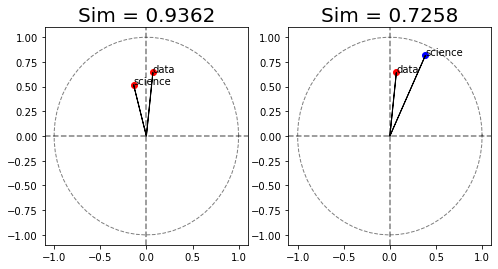

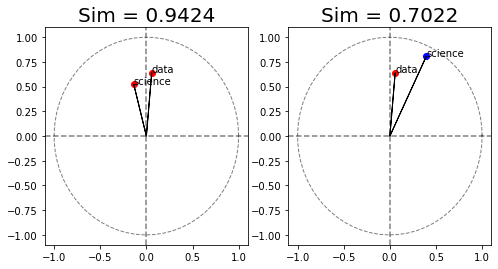

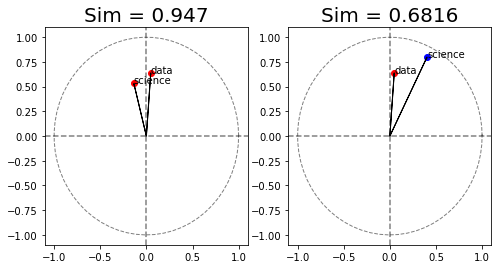

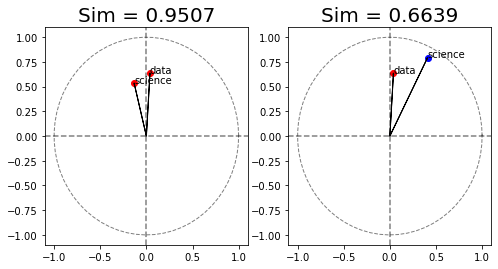

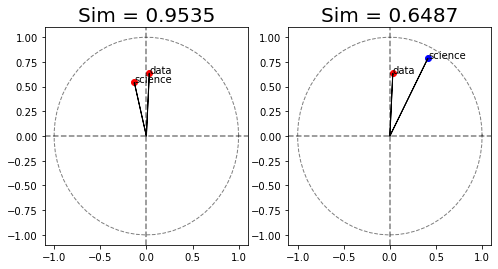

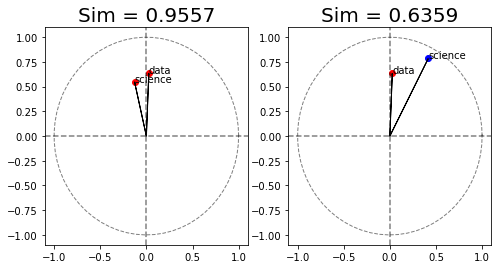

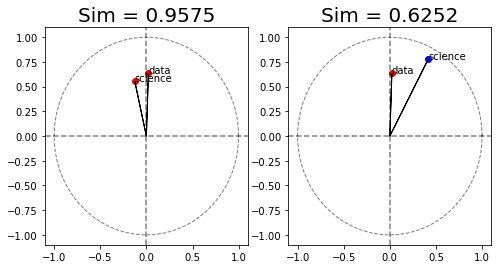

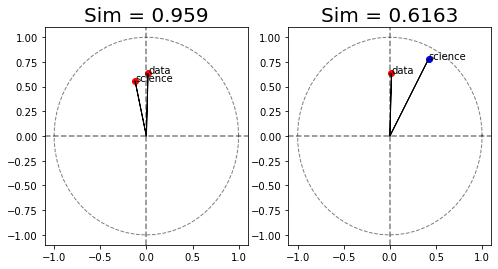

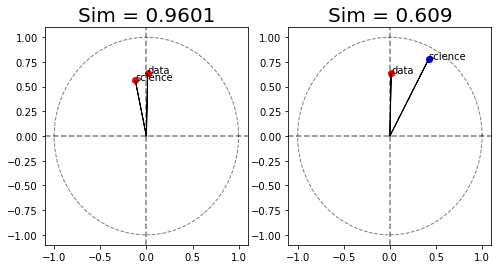

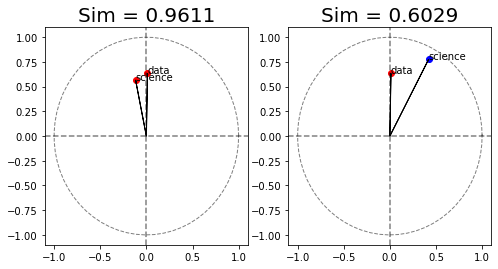

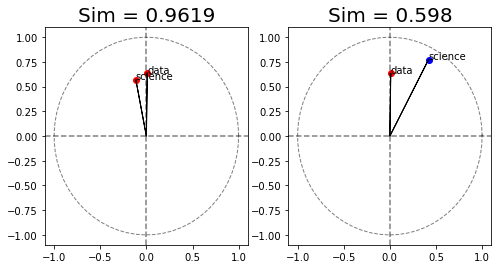

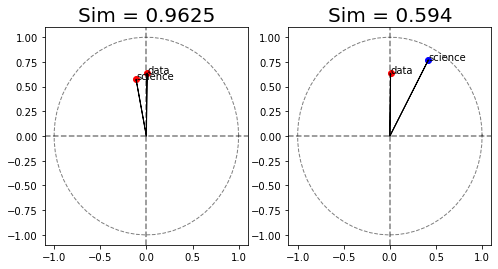

In [17]:
EMBEDDING_SIZE = 5

main_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((main_embeddings**2).sum(axis=1)).reshape(-1,1)
main_embeddings = main_embeddings / row_norms

context_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((context_embeddings**2).sum(axis=1)).reshape(-1,1)
context_embeddings = context_embeddings / row_norms

main_embeddings = pd.DataFrame(data=main_embeddings, index=words)
context_embeddings = pd.DataFrame(data=context_embeddings, index=words)

for _ in range(25):
    main_embeddings, context_embeddings = update_embeddings(df, main_embeddings, context_embeddings, 0.1, ['data', 'science'])

In [18]:
L = []
for w1 in words:
    for w2 in words:
        if w1 != w2:
            sim = 1 - cosine(main_embeddings.loc[w1], main_embeddings.loc[w2])
            L.append((w1,w2,sim))
sorted([item for item in L if item[0] == 'data'], key=lambda t: -t[2])[:10]

[('data', 'statistics', 0.9805463924633809),
 ('data', 'studying', 0.9720048105102664),
 ('data', 'science', 0.9630535714272228),
 ('data', 'thanks', 0.9163345042736353),
 ('data', 'listening', 0.8998332129556577),
 ('data', 'good', 0.8009248591621554),
 ('data', 'fundamentals', 0.7717394621182402),
 ('data', 'became', 0.6911352319296463),
 ('data', 'talk', 0.6240278698776796),
 ('data', 'expert', 0.620681242598661)]

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=2)
transf_embeddings = pca.fit_transform(main_embeddings.values)
words_used = main_embeddings.index

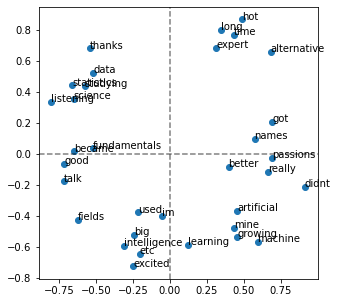

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(transf_embeddings[:,0], transf_embeddings[:,1])
for idx,row in enumerate(transf_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))
plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)

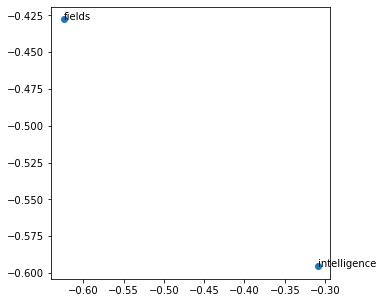

In [22]:
plt.figure(figsize=(5,5))

chosen_idxs = (transf_embeddings[:,0] < -.25) & (transf_embeddings[:,1] < -0.4)
transf_embeddings = transf_embeddings[chosen_idxs]
words_used = words_used[chosen_idxs]

plt.scatter(transf_embeddings[:,0], transf_embeddings[:,1])
for idx,row in enumerate(transf_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))